In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

['2.0_A.npy', '3.0_A.npy', '0.0_A.npy', '1.0_A.npy']
sum  10044.0
sum  10094.0
sum  12572.0
sum  13666.0


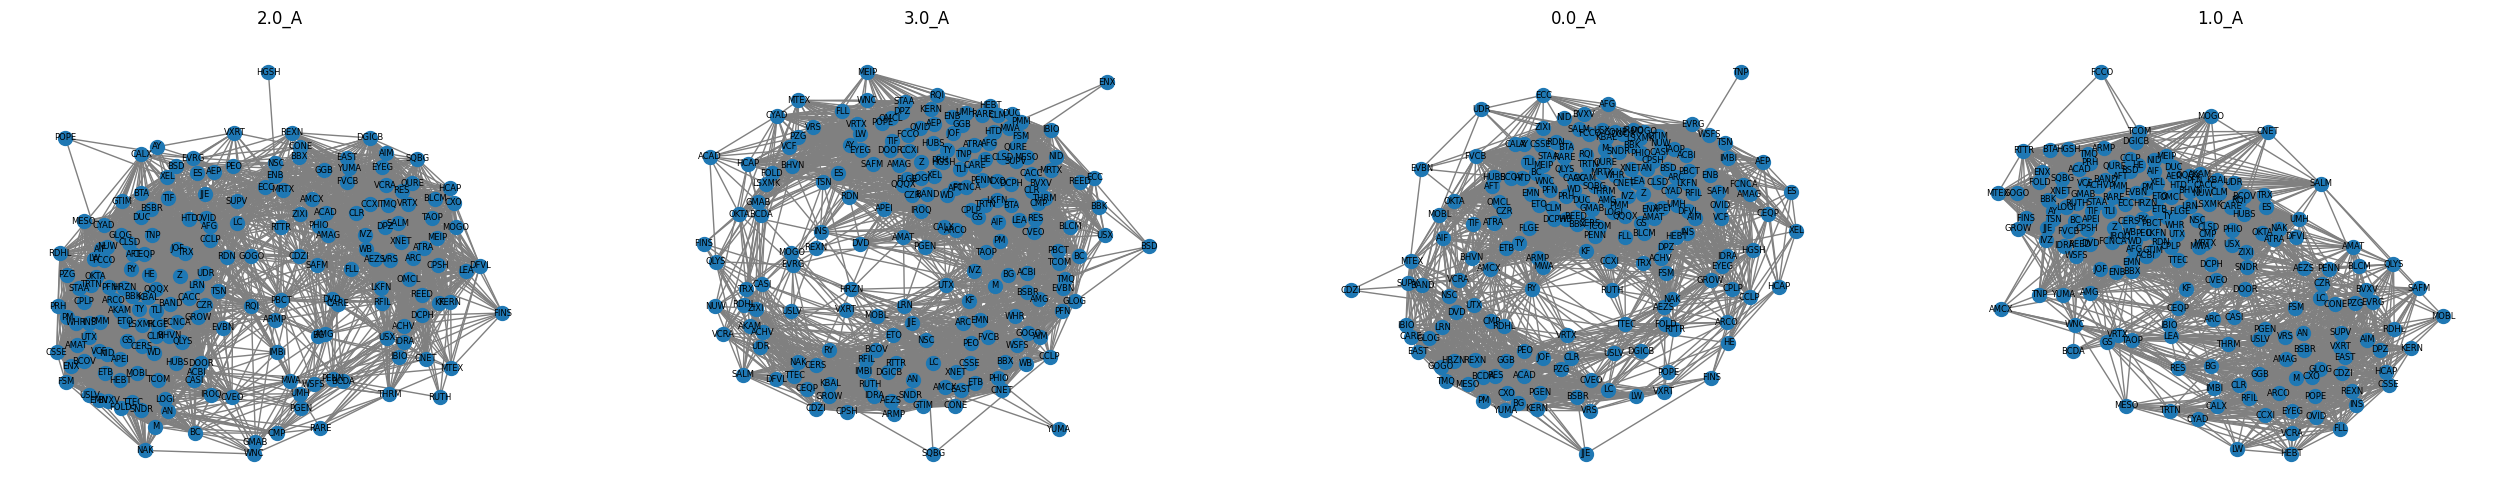

In [3]:
network_files = os.listdir("snapshots")
unweighted_network_files = [s for s in network_files if s.endswith("_A.npy")]
print(unweighted_network_files)

samples = len(unweighted_network_files)

unweighted_network_adj_matricies = [np.load(f"snapshots/{n}") for n in unweighted_network_files]

for A in unweighted_network_adj_matricies:
    print("sum ", np.sum(A))

unweighted_networks = [nx.from_numpy_array(A) for A in unweighted_network_adj_matricies]

adj_close_prices = dict(np.load("stock_item_map_small.npz", allow_pickle=True))
key_enum = list(enumerate(adj_close_prices))

labels = {i: key_enum[i][1] for i in range(len(adj_close_prices))}

fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()
for i,G in enumerate(unweighted_networks):
    pos = nx.kamada_kawai_layout(G)
    axes[i].set_title(unweighted_network_files[i][:-4])
    nx.draw(G, pos, labels=labels, with_labels=True, edge_color='gray', node_size=100, font_size=6, ax=axes[i])


mean degree 52.3125
mean degree 52.572916666666664
mean degree 65.47916666666667
mean degree 71.17708333333333


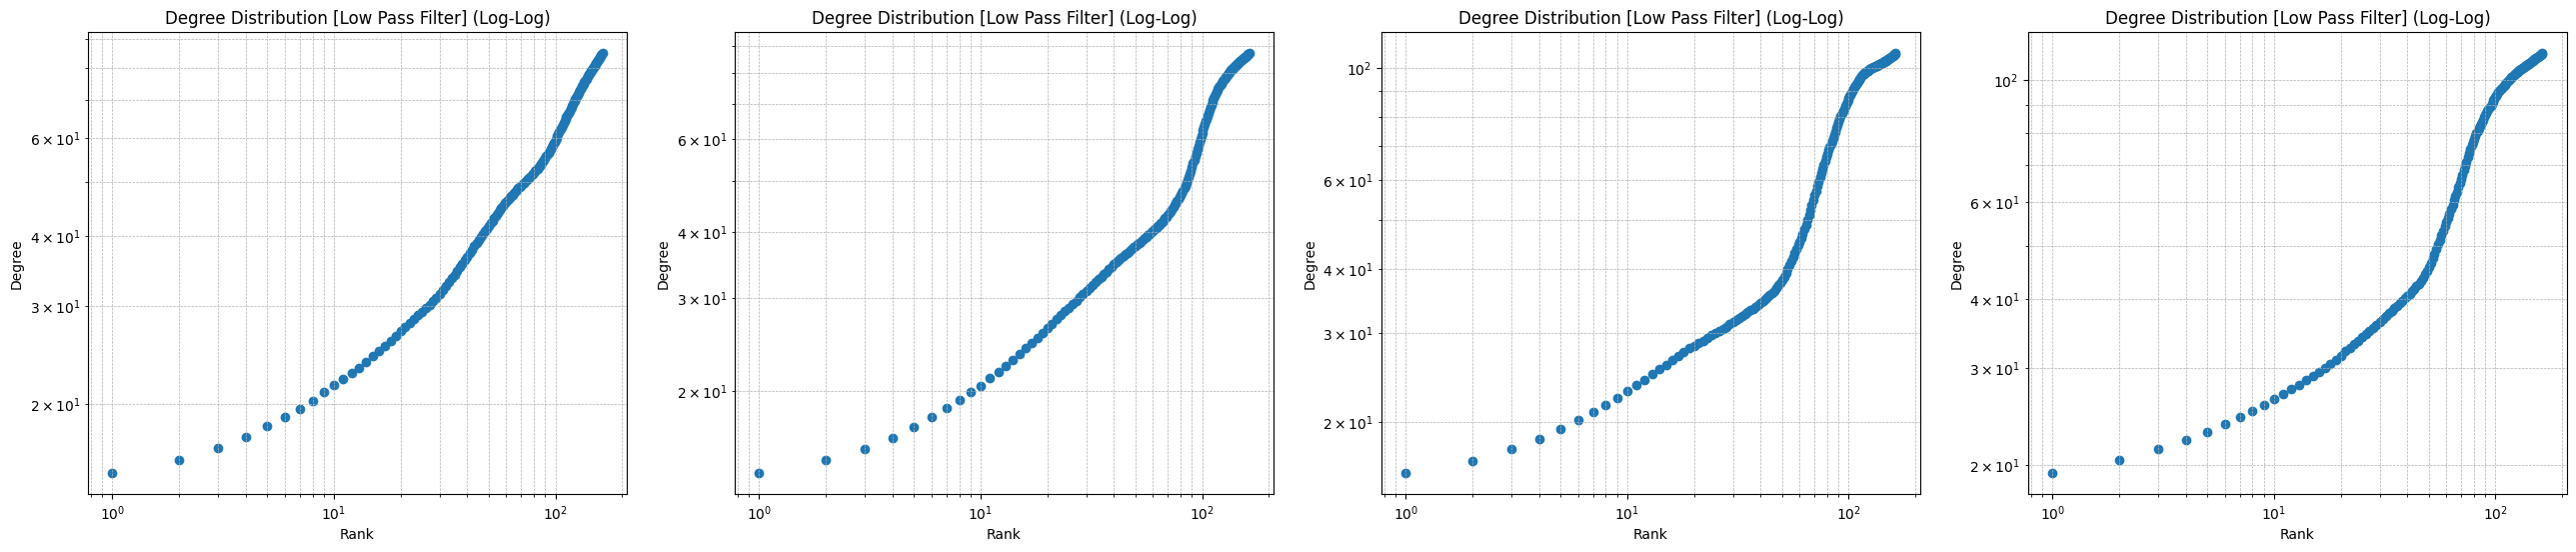

In [4]:
# lets look at the mean degree and do some analysis with the degree distribution

fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

def evaluate_degree_dist(A, i):
    ks = np.sum(A, axis=1)
    ks = np.sort(ks)

    mean_k = np.mean(ks)
    print(f"mean degree {mean_k}")

    # Already sorted: ks
    window_size = 30  # You can tune this value

    # apply a low pass filter
    smoothed_ks = np.convolve(ks, np.ones(window_size)/window_size, mode='valid')

    ranks = np.arange(1, len(smoothed_ks)+1)
    axes[i].scatter(ranks, smoothed_ks)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('Rank')
    axes[i].set_ylabel('Degree')
    axes[i].set_title('Degree Distribution [Low Pass Filter] (Log-Log)')
    axes[i].grid(True, which="both", ls="--", lw=0.5)


for i,A in enumerate(unweighted_network_adj_matricies):
    evaluate_degree_dist(A, i)

In [5]:
from scipy.stats import entropy

def evaluate_degree_dist_entropy(A):
    ks = np.sum(A, axis=1)

    hist, bins = np.histogram(ks, bins=50, density=True)
    hist = hist[hist > 0]  # remove zero bins
    degree_entropy = entropy(hist)
    print(f"Entropy of degree distribution: {degree_entropy:.4f}")

for A in unweighted_network_adj_matricies:
    evaluate_degree_dist_entropy(A)


Entropy of degree distribution: 3.7208
Entropy of degree distribution: 3.6174
Entropy of degree distribution: 3.5269
Entropy of degree distribution: 3.5639


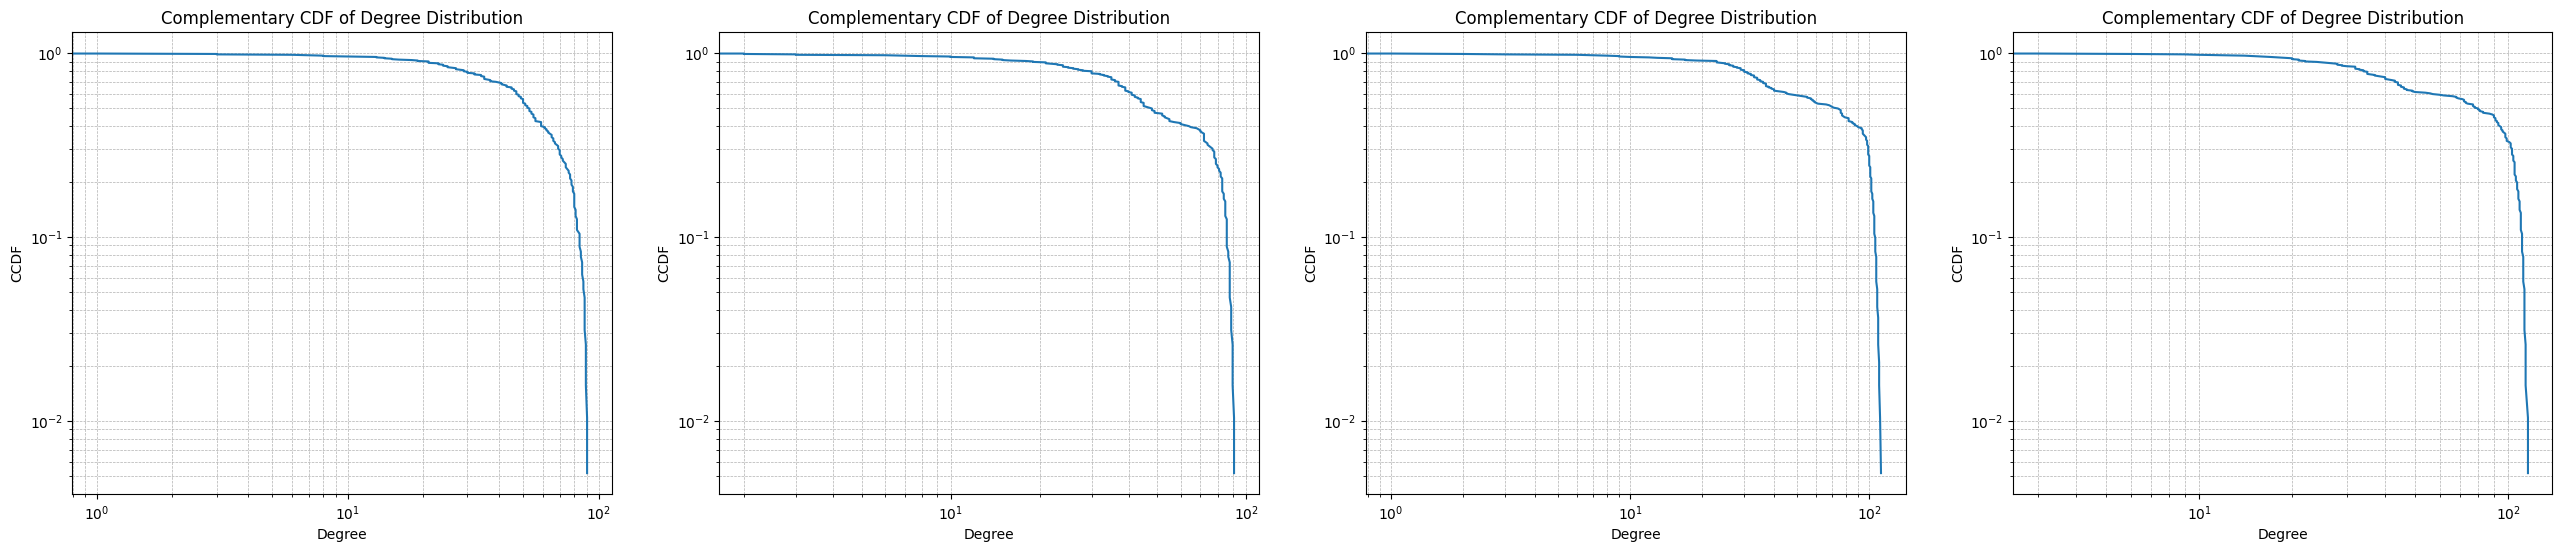

In [6]:
fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

def evaluate_ccdf(A, i):
    ks = np.sum(A, axis=1)
    ks = np.sort(ks)
    ccdf = 1.0 - np.arange(len(ks)) / float(len(ks))

    axes[i].plot(ks, ccdf)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel("Degree")
    axes[i].set_ylabel("CCDF")
    axes[i].set_title("Complementary CDF of Degree Distribution")
    axes[i].grid(True, which="both", ls="--", lw=0.5)

for i,A in enumerate(unweighted_network_adj_matricies):
    evaluate_ccdf(A, i)

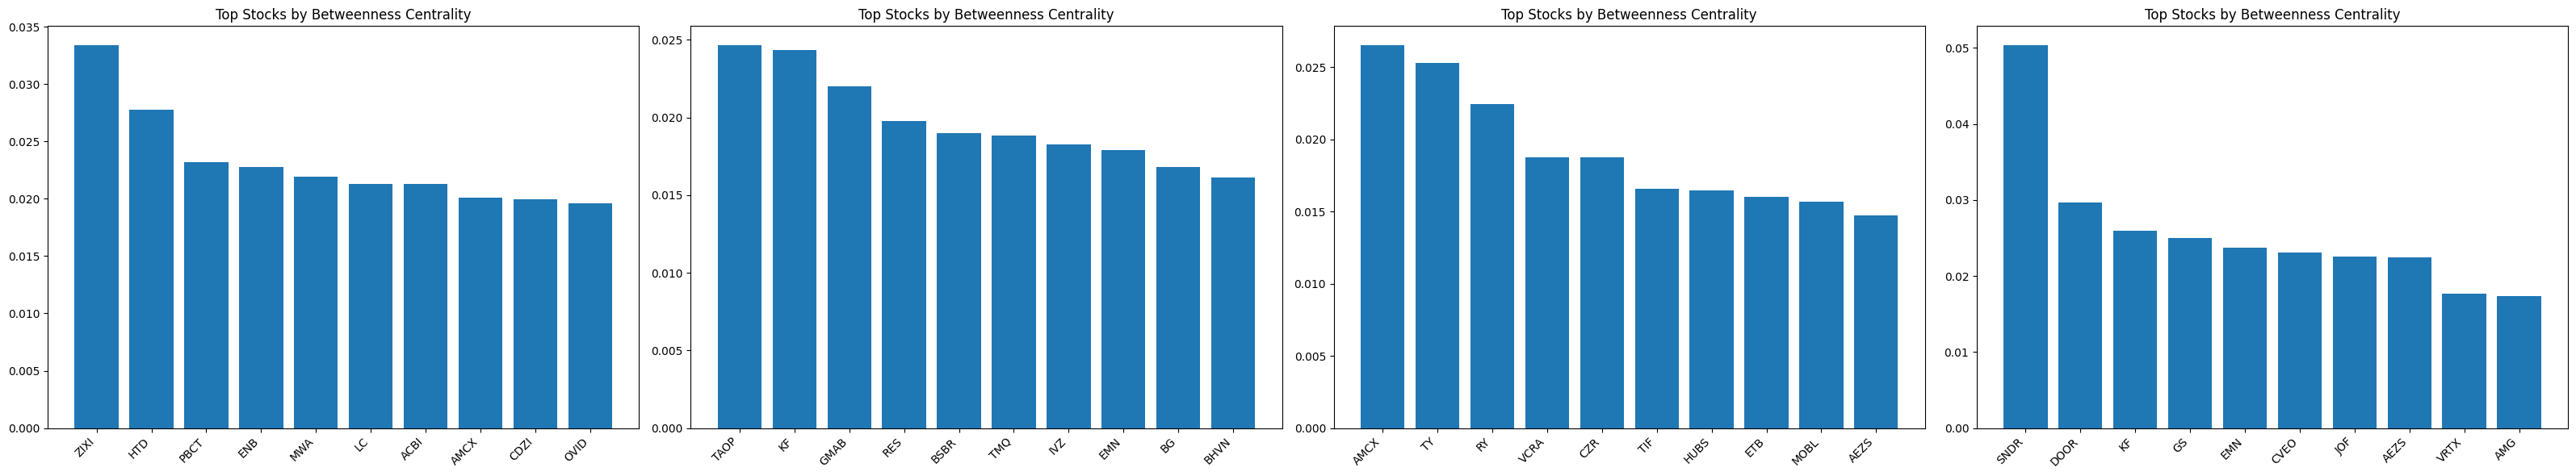

In [7]:
fig, axes = plt.subplots(1, samples, figsize=(8 * samples, 6))
if samples == 1:
    axes = [axes]

def evaluate_betweenness_centrality(G, i):
    betweenness = nx.betweenness_centrality(G)

    top_k = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
    labels = [f"{key_enum[node][1]}" for node, _ in top_k]
    values = [v for _, v in top_k]

    axes[i].bar(labels, values)
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    axes[i].set_title("Top Stocks by Betweenness Centrality")

for i, G in enumerate(unweighted_networks):
    evaluate_betweenness_centrality(G, i)

fig.tight_layout()
plt.show()


In [8]:
def evaluate_clustering_coefficient(G):
    global_clustering = nx.transitivity(G)

    avg_local_clustering = nx.average_clustering(G)

    print("Global Clustering Coefficient:", global_clustering)
    print("Average Local Clustering Coefficient:", avg_local_clustering)

for G in unweighted_networks:
    evaluate_clustering_coefficient(G)

Global Clustering Coefficient: 0.7425135286074682
Average Local Clustering Coefficient: 0.692530917900629
Global Clustering Coefficient: 0.7486092861616298
Average Local Clustering Coefficient: 0.697380812352312
Global Clustering Coefficient: 0.7972271162239034
Average Local Clustering Coefficient: 0.7305372506330089
Global Clustering Coefficient: 0.8243619204836007
Average Local Clustering Coefficient: 0.7759352784698672


In [ ]:
from networkx.algorithms import isomorphism

def evaluate_network_motifs(G):
    motif = nx.Graph()
    motif.add_edges_from([(0, 1), (1, 2), (2, 0)])  # A triangle motif

    # Create a GraphMatcher object to compare the motif to subgraphs of G
    GM = isomorphism.GraphMatcher(G, motif)

    # Check for isomorphisms (subgraphs that match the motif)
    motif_count = sum(1 for _ in GM.subgraph_isomorphisms_iter())
    print(f"Motif found {motif_count} times.")

for G in unweighted_networks:
    evaluate_network_motifs(G)

/tmp/ipykernel_12189/2868142641.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("Set1", len(unique_labels))


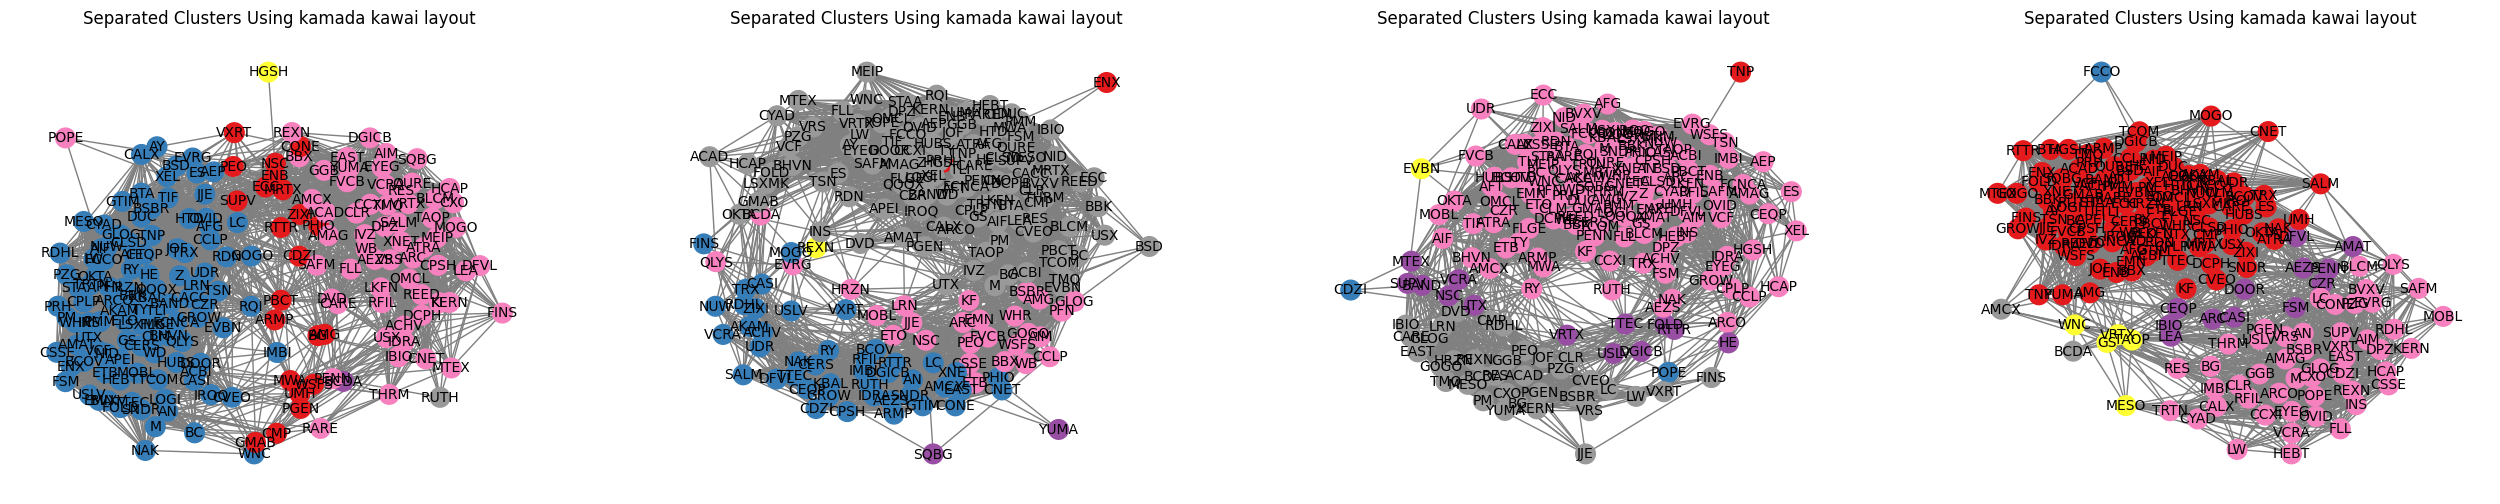

In [304]:
def kmeans(X, k, max_iters=1000, tol=1e-5):
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels

fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

def eigenvalue_clustering(A, i):
    ks = np.sum(A, axis=1)
    D = np.diag(ks)
    L = D - A
    _, U = np.linalg.eigh(L)

    K = 6
    cluster_labels = kmeans(U[:, 1:K+1], K)
    unique_labels = np.unique(cluster_labels)

    G = nx.from_numpy_array(A)
    color_map = plt.cm.get_cmap("Set1", len(unique_labels))
    node_colors = [color_map(label) for label in cluster_labels]

    cluster_nodes = {k: [] for k in unique_labels}
    for j, label in enumerate(cluster_labels):
        cluster_nodes[label].append(j)

    pos = nx.kamada_kawai_layout(G)

    nx.draw(G, pos=pos, labels=labels, with_labels=True,
            node_color=node_colors, edge_color='grey', node_size=200, font_size=10, ax=axes[i])
    axes[i].set_title("Separated Clusters Using kamada kawai layout")
    axes[i].axis('off')

for i, A in enumerate(unweighted_network_adj_matricies):
    eigenvalue_clustering(A, i)

Modularity: 0.382
Modularity: 0.336
Modularity: 0.230
Modularity: 0.249


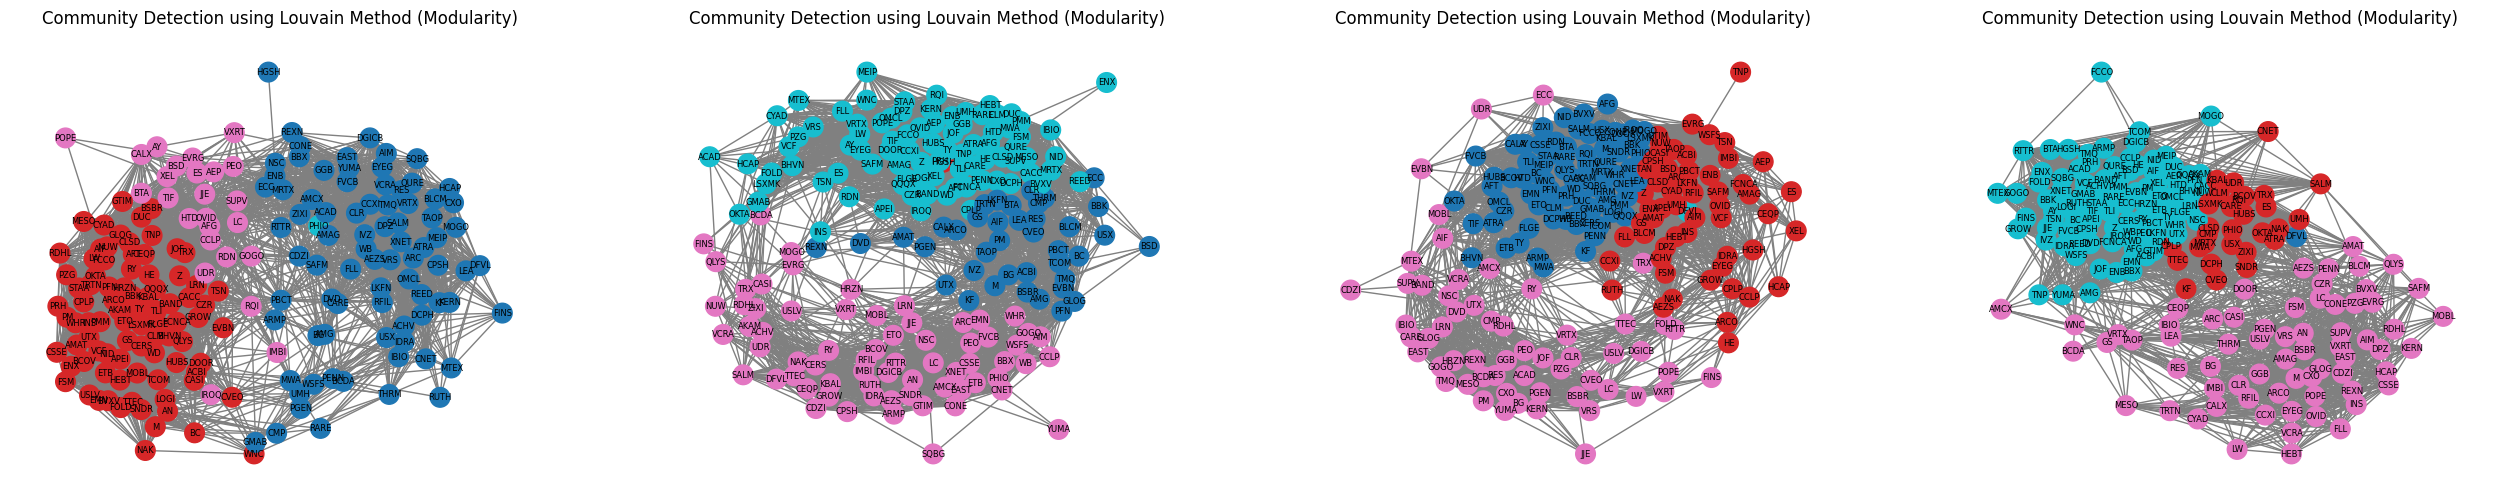

In [ ]:
import community as community_louvain

fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

def louvain_community_detection(G, i):

    partition = community_louvain.best_partition(G)

    color_map = {node: partition[node] for node in G.nodes()}

    colors = [color_map[node] for node in G.nodes()]
    pos = nx.kamada_kawai_layout(G) 

    nx.draw(G, pos, labels=labels, node_color=colors, with_labels=True, node_size=200,font_size=6, edge_color='gray', cmap=plt.cm.tab10, ax=axes[i])
    axes[i].set_title("Community Detection using Louvain Method (Modularity)")

    communities = [set() for _ in range(max(partition.values()) + 1)]
    for node, comm in partition.items():
        communities[comm].add(node)

    mod_score = community_louvain.modularity(partition, G)
    print(f"Modularity: {mod_score:.3f}")

for i, G in enumerate(unweighted_networks):
    louvain_community_detection(G, i)

In [306]:
weighted_network_files = [s for s in network_files if s.endswith("_Aw.npy")]
print(weighted_network_files)

weighted_network_adj_matricies = [np.load(f"snapshots/{n}") for n in unweighted_network_files]
weighted_networks = [nx.from_numpy_array(A) for A in unweighted_network_adj_matricies]

['1.0_Aw.npy', '0.0_Aw.npy', '3.0_Aw.npy', '2.0_Aw.npy']


Modularity: 0.814
Modularity: 0.796
Modularity: 0.608
Modularity: 0.726


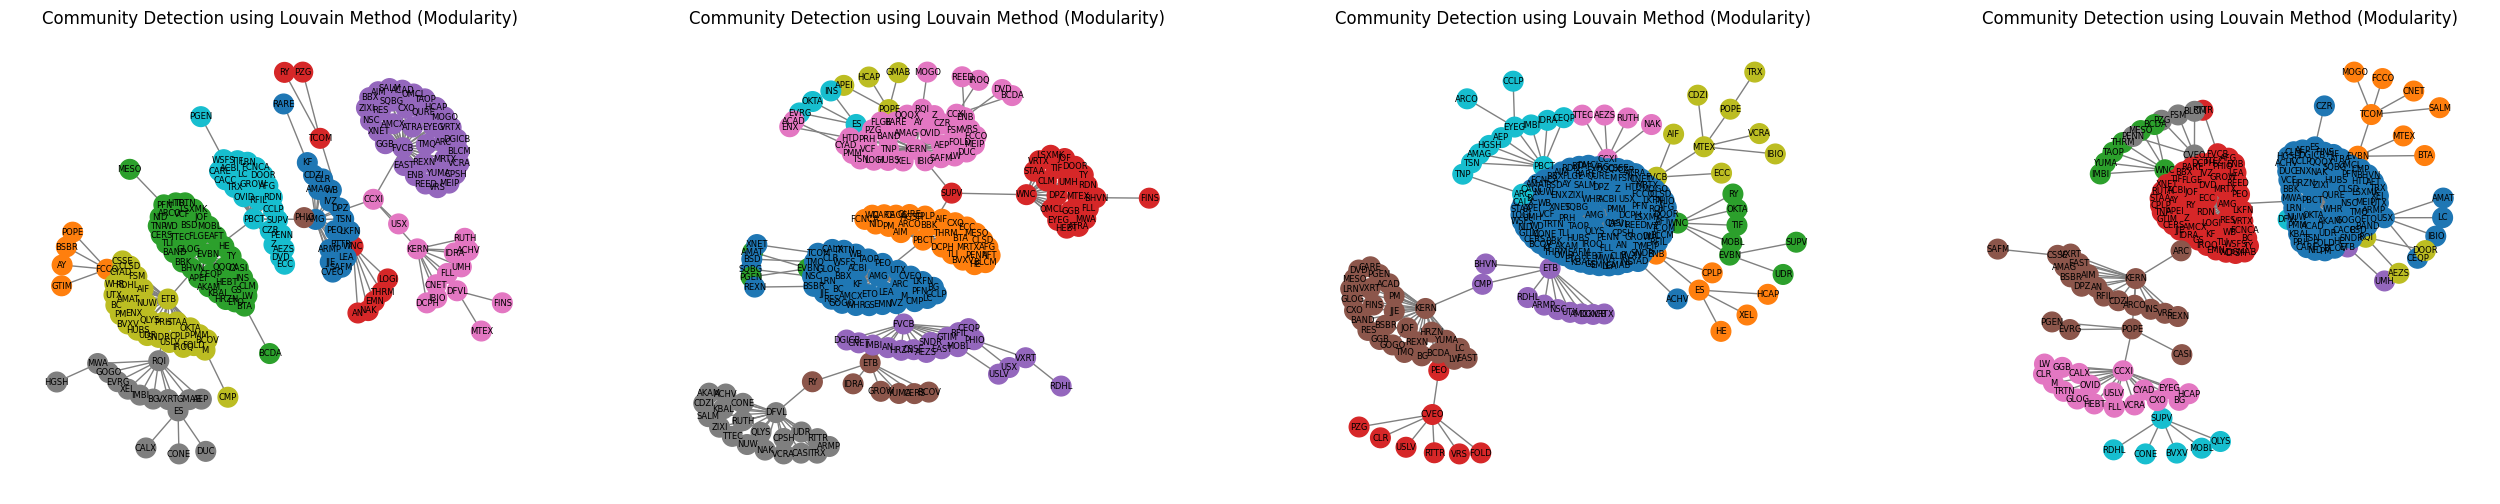

In [ ]:
fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

def evaluate_min_spanning_tree(G, i):
    mst = nx.minimum_spanning_tree(G, weight='weight')
    louvain_community_detection(mst, i)

for i, G in enumerate(weighted_networks):
    evaluate_min_spanning_tree(G, i)

https://www.sciencedirect.com/science/article/abs/pii/S0167947304000258